<a href="https://colab.research.google.com/github/soumik12345/point-cloud-segmentation/blob/dataloader-fix/notebooks/e2e_tensorflow_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf

from typing import List
from tqdm import tqdm
from glob import glob

## Data loading

In [2]:
dataset_url = "https://github.com/soumik12345/point-cloud-segmentation/releases/download/v0.1/shapenet.zip"

dataset_path = tf.keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

In [4]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

metadata

{'Airplane': {'colors': ['blue', 'green', 'red', 'pink'],
  'directory': '02691156',
  'lables': ['wing', 'body', 'tail', 'engine']},
 'Bag': {'colors': ['blue', 'green'],
  'directory': '02773838',
  'lables': ['handle', 'body']},
 'Cap': {'colors': ['blue', 'green'],
  'directory': '02954340',
  'lables': ['panels', 'peak']},
 'Car': {'colors': ['blue', 'green', 'red'],
  'directory': '02958343',
  'lables': ['wheel', 'hood', 'roof']},
 'Chair': {'colors': ['blue', 'green', 'red', 'pink'],
  'directory': '03001627',
  'lables': ['leg', 'arm', 'back', 'seat']},
 'Earphone': {'colors': ['blue', 'green'],
  'directory': '03261776',
  'lables': ['earphone', 'headband']},
 'Guitar': {'colors': ['blue', 'green', 'red'],
  'directory': '03467517',
  'lables': ['head', 'body', 'neck']},
 'Knife': {'colors': ['blue', 'green'],
  'directory': '03624134',
  'lables': ['handle', 'blade']},
 'Lamp': {'colors': ['blue', 'green', 'red'],
  'directory': '03636649',
  'lables': ['canopy', 'lampshade'

In [5]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]
VAL_SPLIT = 0.2
N_SAMPLE_POINTS = 1024

## Filtering the files that have labels

In [6]:
points_files_with_keys = set()
points_files = glob(os.path.join(points_dir, "*.pts"))


for point_file in tqdm(points_files):
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data = {}

    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = 0  # Dummy assignment only used as a placeholder.
    try:
        label_data = np.vstack(tuple([label_data[key] for key in LABELS]))
        points_files_with_keys.add(point_file)
    except:
        continue

points_files_with_keys = list(points_files_with_keys)
len(points_files_with_keys)

100%|██████████| 4045/4045 [00:00<00:00, 24019.67it/s]


3694

## Prepare dataset utilities

In [7]:
def process_single_point_file(point_filepath: str):
    # Load the point cloud from disk.
    point_filepath = point_filepath.numpy().decode("utf-8")
    point_cloud = np.loadtxt(point_filepath)

    # Parse the file-id.
    file_id = point_filepath.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0

    # Parse the labels.
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        label_data[label] = np.loadtxt(label_file).astype("float32")
        num_labels = len(label_data[label])

    label_map = ["none"] * num_labels
    for label in LABELS:
        for i, data in enumerate(label_data[label]):
            label_map[i] = label if data == 1 else label_map[i]
    label_data = [
        LABELS.index(label) if label != "none" else len(LABELS)
        for label in label_map
    ]
    label_cloud = tf.keras.utils.to_categorical(
        label_data, num_classes=len(LABELS) + 1
    )

    # Sample `N_SAMPLE_POINTS` from the point and label clouds randomly.
    sampled_point_cloud, sampled_label_cloud = random_sampler(point_cloud, label_cloud)

    # Normalizing point cloud.
    normalized_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    normalized_point_cloud /= np.max(np.linalg.norm(normalized_point_cloud, axis=1))

    return normalized_point_cloud, sampled_label_cloud


def random_sampler(point_cloud: np.ndarray, label_cloud: np.ndarray):
    n_points = len(point_cloud)

    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(n_points)), N_SAMPLE_POINTS)

    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([point_cloud[i] for i in sampled_indices])

    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([label_cloud[i] for i in sampled_indices])

    return sampled_point_cloud, sampled_label_cloud


def tf_process_point_file(point_filepath: str):
    data_tuple = tf.py_function(
        process_single_point_file, [point_filepath], [tf.float64, tf.float32]
    )
    return data_tuple


def augment(point_cloud_batch, label_cloud_batch):
    # Jitter point and label clouds.
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    label_cloud_batch += tf.cast(noise, tf.float32)

    return point_cloud_batch, label_cloud_batch


def prepare_dataset(
    point_filepaths: List[str], is_train: bool = True, batch_size: int = 16
):
    point_files_ds = tf.data.Dataset.from_tensor_slices(point_filepaths)
    if is_train:
        point_files_ds = point_files_ds.shuffle(batch_size * 100)

    point_ds = point_files_ds.map(
        tf_process_point_file, num_parallel_calls=tf.data.AUTOTUNE
    )
    point_ds = point_ds.batch(batch_size)
    if is_train:
        point_ds = point_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    return point_ds

## Create `tf.data.Dataset` objects

In [8]:
point_files_ds = tf.data.Dataset.from_tensor_slices(points_files_with_keys)
single_pcloud_file = next(iter(point_files_ds))
single_pcloud_file

<tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/.keras/datasets/PartAnnotation/02691156/points/b831f60f211435df5bbc861d0124304c.pts'>

In [9]:
single_pcloud_file = next(iter(point_files_ds))
point_cloud, label_cloud = process_single_point_file(single_pcloud_file)
point_cloud.shape, label_cloud.shape

((1024, 3), (1024, 5))

### Visualizing sample data

In [12]:
def visualize_data_plotly(point_cloud, labels):
    fig = px.scatter_3d(
        pd.DataFrame(
            data={
                'x': point_cloud[:, 0],
                'y': point_cloud[:, 1],
                'z': point_cloud[:, 2],
                'label': labels
            }
        ), x="x", y="y", z="z",
        color="label", labels={"label": "Label"},
        color_discrete_sequence=COLORS + ['black'],
        category_orders={"label": LABELS + ['none']}
    )
    fig.show()

In [13]:
label_map = LABELS + ['none']
visualize_data_plotly(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])

In [14]:
def visualize_data_plt(point_cloud, labels):
    color_map = COLORS + ['black']
    df = pd.DataFrame(
        data={
            'x': point_cloud[:, 0],
            'y': point_cloud[:, 1],
            'z': point_cloud[:, 2],
            'label': labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')  
    for index, label in enumerate(LABELS + ['none']):
        c_df = df[df['label'] == label]
        try:
            ax.scatter(
                c_df['x'], c_df['y'], c_df['z'],
                label=label, alpha = 0.5, c=color_map[index]
            ) 
        except IndexError:
            pass
    ax.legend()
    plt.show()

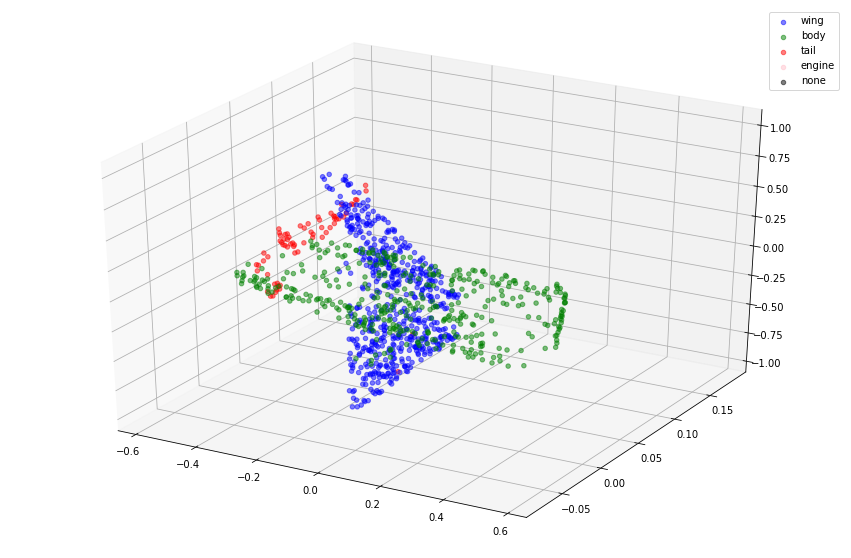

In [15]:
visualize_data_plt(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])

In [16]:
point_ds = point_files_ds.map(
    tf_process_point_file, num_parallel_calls=tf.data.AUTOTUNE
)

for point_cloud, label_cloud in point_ds.take(5):
    print(point_cloud.shape, label_cloud.shape)

(1024, 3) (1024, 5)
(1024, 3) (1024, 5)
(1024, 3) (1024, 5)
(1024, 3) (1024, 5)
(1024, 3) (1024, 5)


In [17]:
split_index = int(len(points_files_with_keys) * (1 - VAL_SPLIT))
train_point_cloud_files = points_files_with_keys[:split_index]
val_point_cloud_files = points_files_with_keys[split_index:]

print(f"Total training files: {len(train_point_cloud_files)}.")
print(f"Total validation files: {len(val_point_cloud_files)}.")

Total training files: 2955.
Total validation files: 739.


In [18]:
train_ds = prepare_dataset(train_point_cloud_files)
validation_ds = prepare_dataset(val_point_cloud_files, is_train=False)

In [19]:
train_ds.element_spec, validation_ds.element_spec

((TensorSpec(shape=<unknown>, dtype=tf.float64, name=None),
  TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)),
 (TensorSpec(shape=<unknown>, dtype=tf.float64, name=None),
  TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)))

In [20]:
for single_batch in train_ds.take(1):
    break
    
single_batch[0].shape, single_batch[1].shape

(TensorShape([16, 1024, 3]), TensorShape([16, 1024, 5]))